In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Carrega a tabela imortação
imp_fert=pd.read_csv('~/git/BD/temp/imp_fert_mun_cat.csv').reset_index(drop=True)
imp_fert.shape

(119071, 15)

### Identifica as colunas quantitativas

In [2]:
col_quanti=[x for x in imp_fert.columns if x[:2]=='VL' or x[:2]=='KG']
col_quanti

['KG_LIQUIDO', 'VL_FOB']

### Avalia impacto e elimina registros com quantidade igual a zero

In [3]:
# Avalia impacto na eliminação de registros com quantidade zero
for q in col_quanti:
    print(f"{q} possui {round(100*imp_fert[imp_fert[q]==0].shape[0]/imp_fert.shape[0],1)} % dos registros com valor igual a zero.")

KG_LIQUIDO possui 0.5 % dos registros com valor igual a zero.
VL_FOB possui 0.0 % dos registros com valor igual a zero.


In [4]:
for q in col_quanti:
    par=imp_fert[imp_fert[q]==0][[x for x in col_quanti if x not in [q]]].sum()
    tot=imp_fert[imp_fert[q]!=0][[x for x in col_quanti if x not in [q]]].sum()
    print('Qdo ',q,'= 0:')
    print(f"{100*(par/tot)} % do total.")
    print()

Qdo  KG_LIQUIDO = 0:
VL_FOB    0.000068
dtype: float64 % do total.

Qdo  VL_FOB = 0:
KG_LIQUIDO    1.766114e-09
dtype: float64 % do total.



In [5]:
# Descarta registros com valor igual a zero
for c in col_quanti:
    imp_fert=imp_fert[imp_fert[c]>0]

### Corrige inflação monetária

In [6]:
# Carrega função de correção do dólar
%run '/home/andre301267/git/BD/Comexstat/function/corrige_inflação_dólar.ipynb'


Função ***corrige_inflação_dólar(df_ano_mes_valor,col_vl_name)*** disponível.



In [7]:
# Identifica valores a serem corrigidos da inflação
col_val=[x for x in imp_fert.columns if x[:2]=='VL']
col_val

['VL_FOB']

In [8]:
# Salva backup e corrige inflação
for cv in col_val:
    imp_fert.insert(7,cv+'_orig',imp_fert[cv])
    imp_fert=corrige_inflação_dólar(imp_fert,cv)

In [9]:
imp_fert.columns

Index(['CO_ANO', 'CO_MES', 'CO_SH4', 'CO_PAIS', 'UF', 'CO_MUN', 'KG_LIQUIDO',
       'VL_FOB_orig', 'VL_FOB', 'NO_SH4_POR', 'CO_PAIS_ISOA3', 'NO_PAIS',
       'CO_UF', 'NO_UF', 'NO_REGIAO', 'nick_sh4'],
      dtype='object')

### Clusteriza NCM

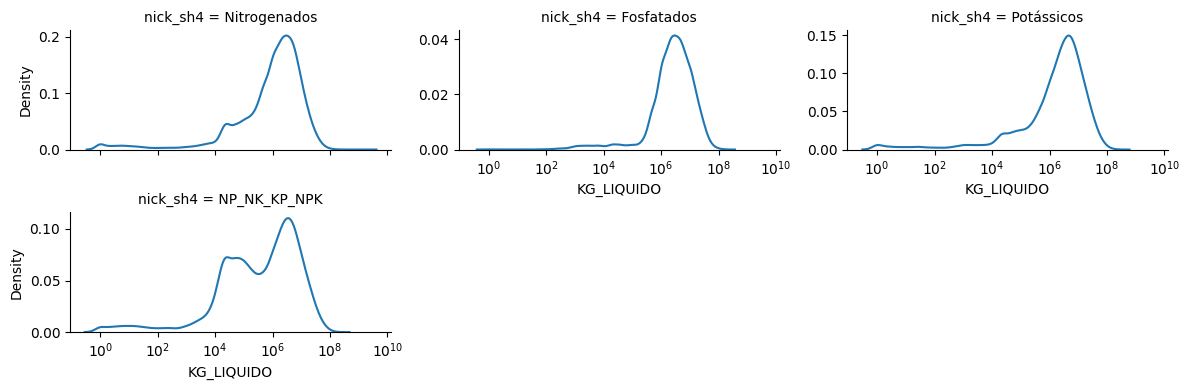

In [10]:
sns.displot(kind='kde',data=imp_fert,x='KG_LIQUIDO',col='nick_sh4',col_wrap=3,height=2,aspect=2,\
            log_scale=True,facet_kws=dict(sharey=False))

In [11]:
%run '/home/andre301267/git/BD/Comexstat/function/clusteriza_sh4.ipynb'

** Função clusteriza_sh4(imp_fert,n_cluster=4) disponível **


In [12]:
n_c=[3,3,4,3]

In [13]:
q=pd.DataFrame()
a=0
for nick_sh4 in imp_fert.nick_sh4.unique():
    t=imp_fert[(imp_fert.nick_sh4==nick_sh4)]
    t=clusteriza_sh4(t,n_cluster=n_c[a])
    a+=1
    q=pd.concat([q,t])

imp_fert=q

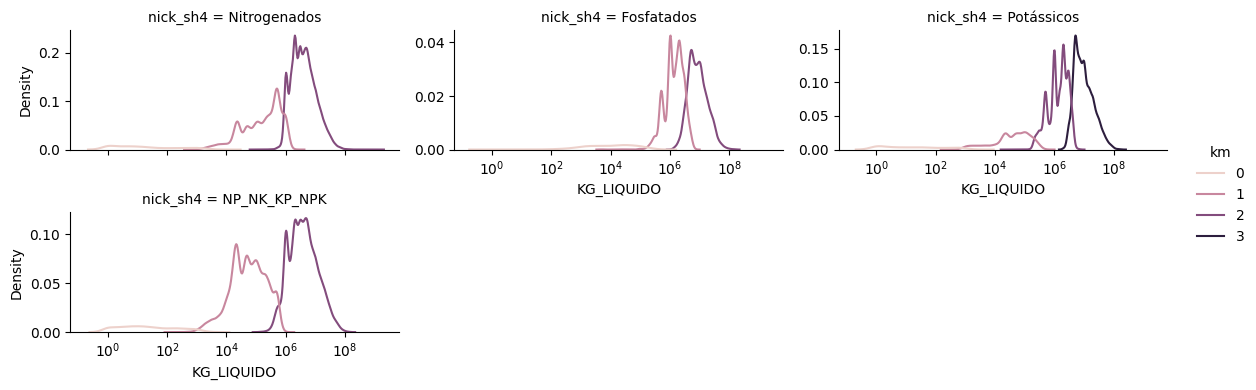

In [14]:
sns.displot(kind='kde',data=imp_fert,x='KG_LIQUIDO',col='nick_sh4', hue='km',col_wrap=3,height=2,aspect=2,\
            log_scale=True,facet_kws=dict(sharey=False))

### Corrige oputliers através do preço

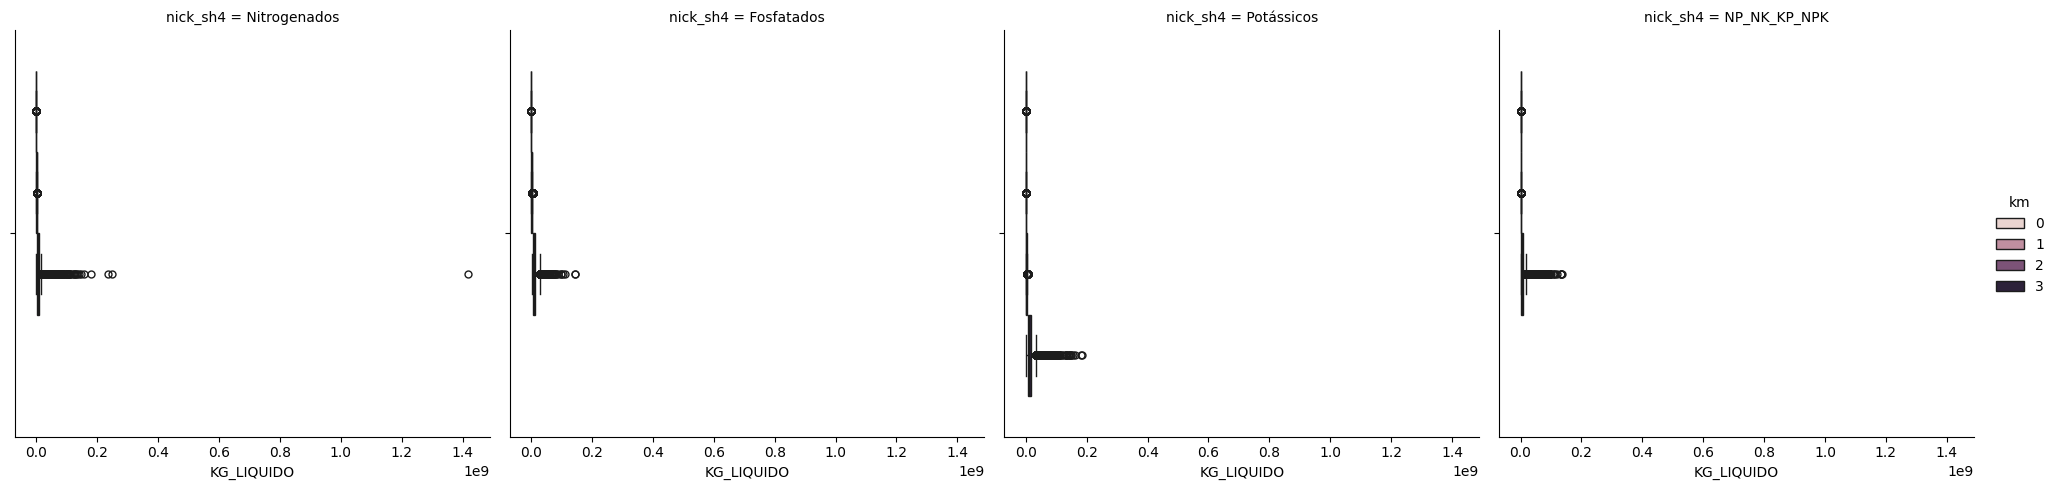

In [15]:
sns.catplot(data=imp_fert,x='KG_LIQUIDO',hue='km',col='nick_sh4',kind='box')

Confere maior registro de peso:

In [16]:
imp_fert[imp_fert.KG_LIQUIDO==imp_fert.KG_LIQUIDO.max()]

,CO_ANO,CO_MES,CO_SH4,CO_PAIS,UF,CO_MUN,KG_LIQUIDO,VL_FOB_orig,VL_FOB,NO_SH4_POR,...,NO_PAIS,CO_UF,NO_UF,NO_REGIAO,nick_sh4,log_kg,log_fob,s_log_kg,s_log_fob,km
5985,2003,8,3102,831,BA,2905701,1418071545,5604808,9804328,"Adubos (fertilizantes) minerais ou químicos, a...",...,Ucrânia,32,Bahia,REGIAO NORDESTE,Nitrogenados,9.151698,6.991418,1.0,0.866375,2


Confere a soma geral

In [17]:
imp_fert[['KG_LIQUIDO','VL_FOB']].sum()/10**9

KG_LIQUIDO    566.214817
VL_FOB        236.619902
dtype: float64

Carrega função para correção via preço

In [18]:
%run '/home/andre301267/git/BD/Comexstat/function/corr_kg_fob_via_preço.ipynb'

** Função corr_kg_fob_via_preço(imp_fert,z=3) disponível **


Corrige

In [19]:
q=pd.DataFrame()
z=4
k=0
f=0
for sh4 in imp_fert.CO_SH4.unique():
    for km in imp_fert.km.unique():
        t=imp_fert[(imp_fert.CO_SH4==sh4)&(imp_fert.km==km)]
        t, len_err_kg, len_err_fob=corr_kg_fob_via_preço(t,z=z)
        q=pd.concat([q,t])
        k+=len_err_kg
        f+=len_err_fob

print(f"Através do preço, foram corrigidos {k} registros de kg e {f} registros de valor fob, que estavam a mais de {z} vezes \
o desvio padrão\nde distância da média (z score).")

imp_fert=q.copy()

Através do preço, foram corrigidos 142 registros de kg e 52 registros de valor fob, que estavam a mais de 4 vezes o desvio padrão
de distância da média (z score).


Confere maior registro de peso:

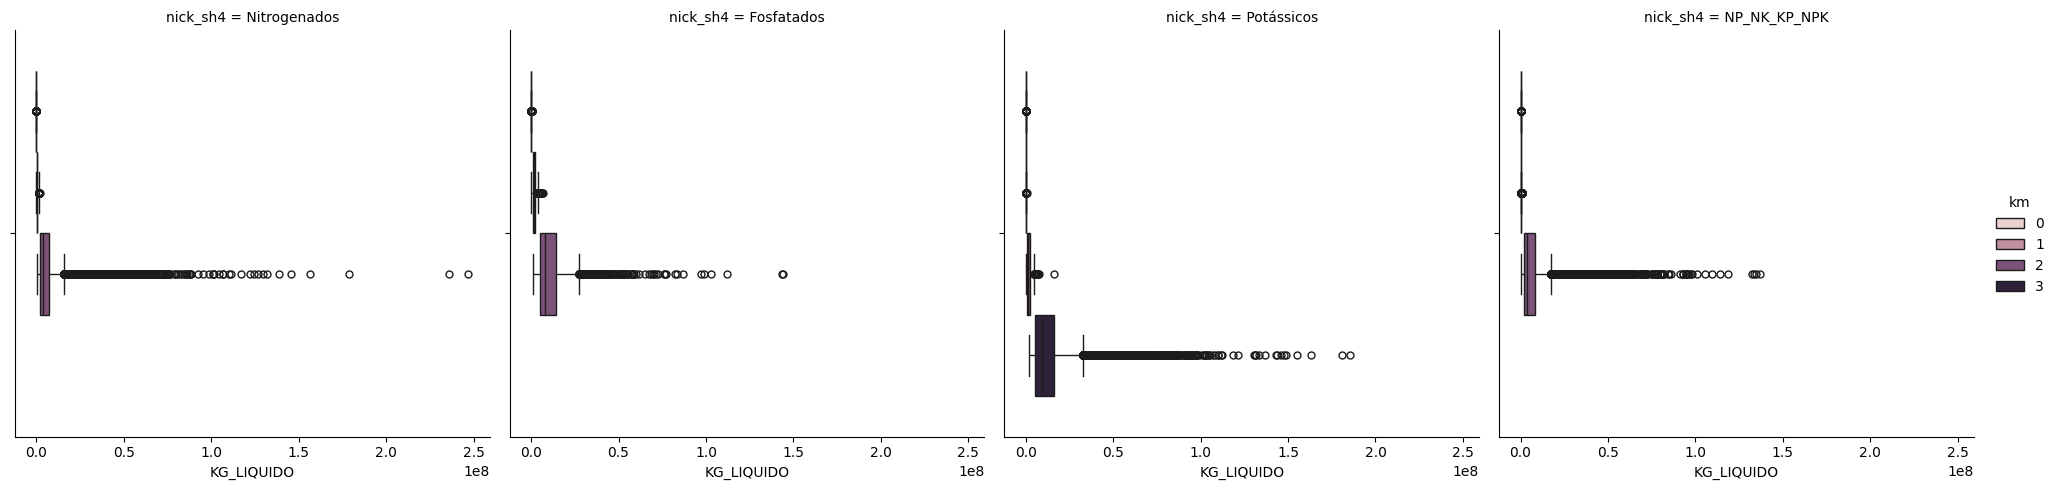

In [20]:
sns.catplot(data=imp_fert,x='KG_LIQUIDO',hue='km',col='nick_sh4',kind='box')

Confere a soma geral

In [21]:
imp_fert[['KG_LIQUIDO','VL_FOB']].sum()/10**9

KG_LIQUIDO    565.165121
VL_FOB        236.581177
dtype: float64

In [22]:
imp_fert.to_csv('/home/andre301267/git/BD/temp/imp_fert_mun_quanti.csv',index=False)